In [186]:
# Enable autoreload for development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
# Setup
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [188]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [189]:
# Load and clean data
from src.load_data import load_data

In [190]:
df = load_data()
df

,No.,Diameter (mm),Speed (rpm),Feed (mm/rev),Thrust force (N),Torque (Nm),Flank wear (mm),Workpiece
0,1,9.0,500,0.13,1088.1,10.67,0.10,cast iron
1,2,9.0,500,0.18,1435.1,14.66,0.13,cast iron
2,3,9.0,500,0.25,1588.3,16.04,0.06,cast iron
3,4,9.0,500,0.36,1669.8,17.12,0.09,cast iron
4,5,9.0,400,0.13,1150.9,11.22,0.12,cast iron
...,...,...,...,...,...,...,...,...
160,161,10.0,1000,0.50,1960.0,18.13,0.13,copper
161,162,7.5,1000,0.50,784.0,7.35,0.10,copper
162,163,5.0,1000,0.50,651.0,6.17,0.07,copper
163,164,10.0,1000,0.71,2009.0,20.58,0.17,copper


In [191]:
from src.clean_data import clean_dataset, add_features
df_clean = clean_dataset(df)
df_clean = add_features(df_clean)  # ⬅️ Feature Engineering : this includes new features

In [192]:
# Identify one-hot workpiece columns (e.g., 'workpiece_b', 'workpiece_c', etc.)
workpiece_cols = [col for col in df_clean.columns if col.startswith('workpiece_')]

In [193]:
# Confirm all required columns exist
print("Cleaned Columns:", df_clean.columns.tolist())

Cleaned Columns: ['no.', 'diameter_(mm)', 'speed_(rpm)', 'feed_(mm/rev)', 'thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)', 'workpiece_copper', 'workpiece_mild steel', 'speed_per_dia', 'log_feed', 'torque_feed_ratio', 'material_hardness', 'feed_squared', 'speed_squared']


In [194]:
# Features and targets
X = df_clean[['diameter_(mm)', 'speed_(rpm)', 'feed_(mm/rev)',
              'speed_per_dia', 'log_feed',
              'torque_feed_ratio', 'material_hardness',
              'feed_squared', 'speed_squared'] + workpiece_cols]
import numpy as np
#y = df_clean[['thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)']]
# Log-transform flank wear only
y = df_clean[['thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)']].copy()
y['flank_wear_(mm)'] = np.log1p(y['flank_wear_(mm)'])  # log(1 + x) to avoid log(0)



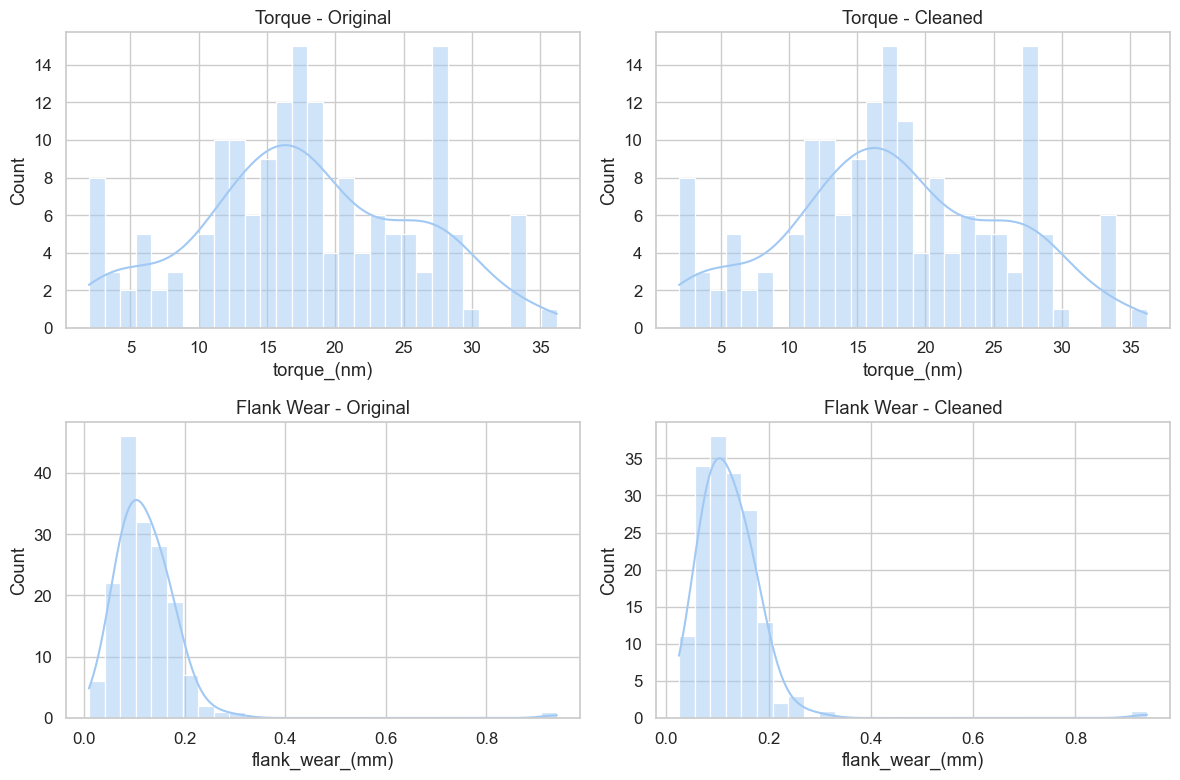

In [195]:
# Visualize distributions before and after cleaning
df_orig = load_data()
df_orig.columns = df_orig.columns.str.strip().str.lower().str.replace(' ', '_')

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df_orig['torque_(nm)'], bins=30, ax=axs[0,0], kde=True)
axs[0,0].set_title("Torque - Original")

sns.histplot(df_clean['torque_(nm)'], bins=30, ax=axs[0,1], kde=True)
axs[0,1].set_title("Torque - Cleaned")

sns.histplot(df_orig['flank_wear_(mm)'], bins=30, ax=axs[1,0], kde=True)
axs[1,0].set_title("Flank Wear - Original")

sns.histplot(df_clean['flank_wear_(mm)'], bins=30, ax=axs[1,1], kde=True)
axs[1,1].set_title("Flank Wear - Cleaned")

plt.tight_layout()
plt.show()

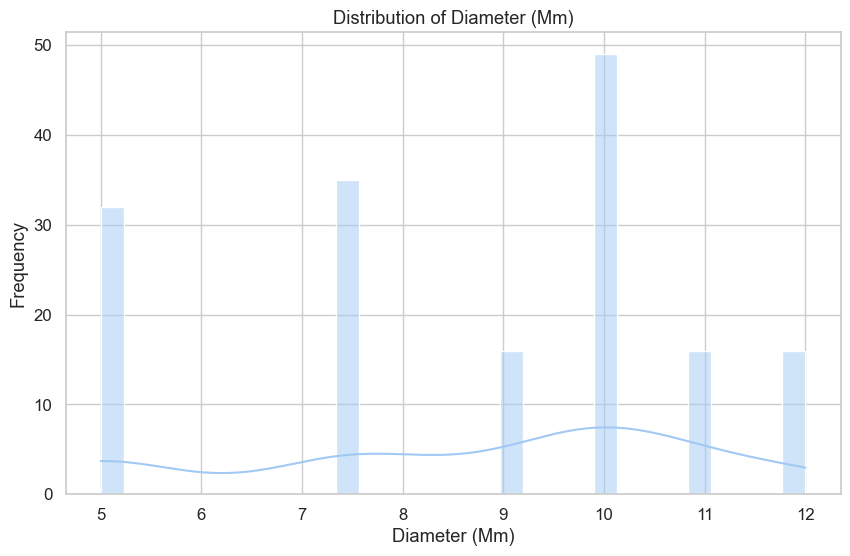

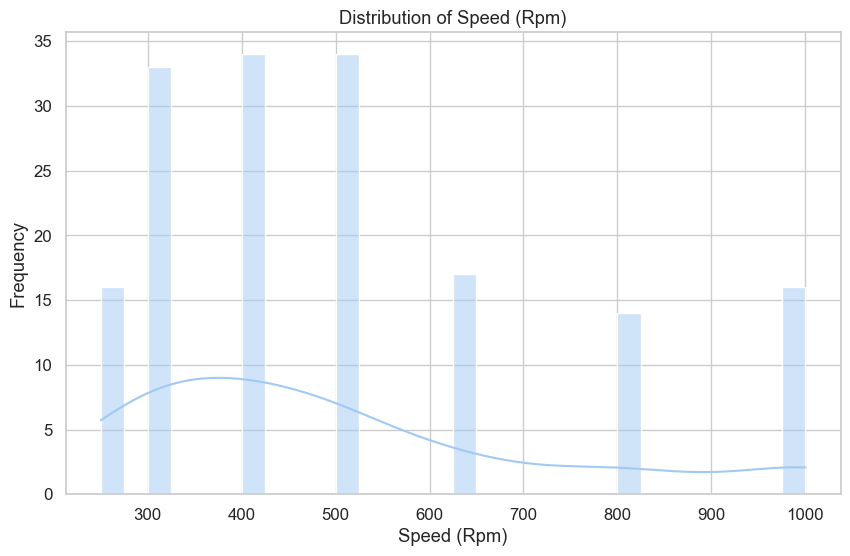

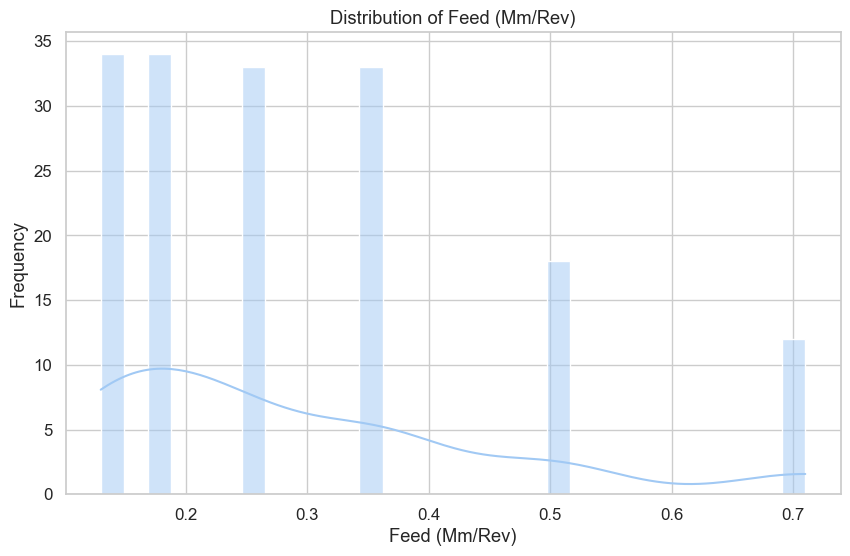

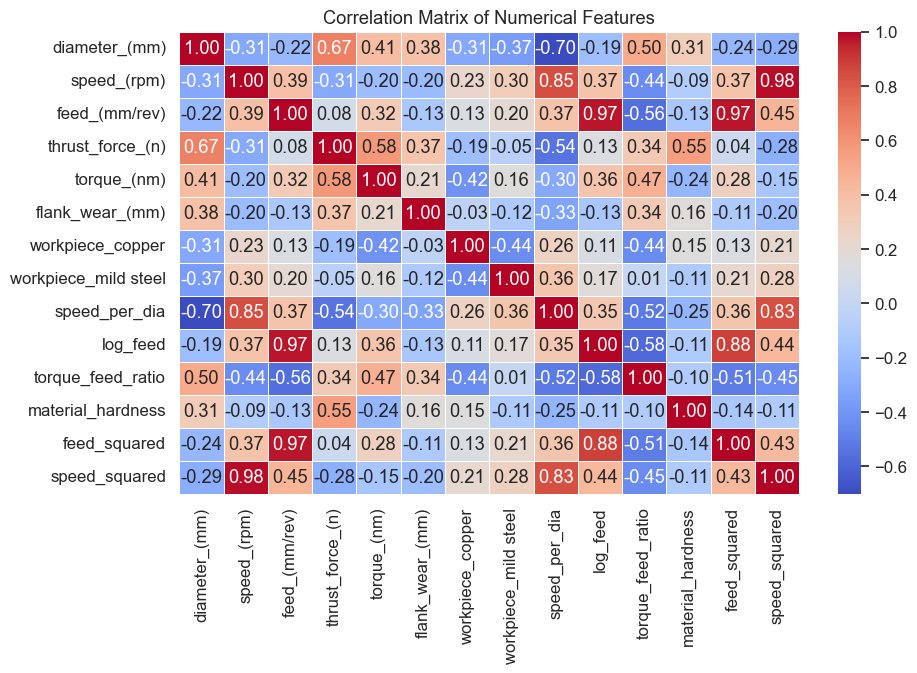

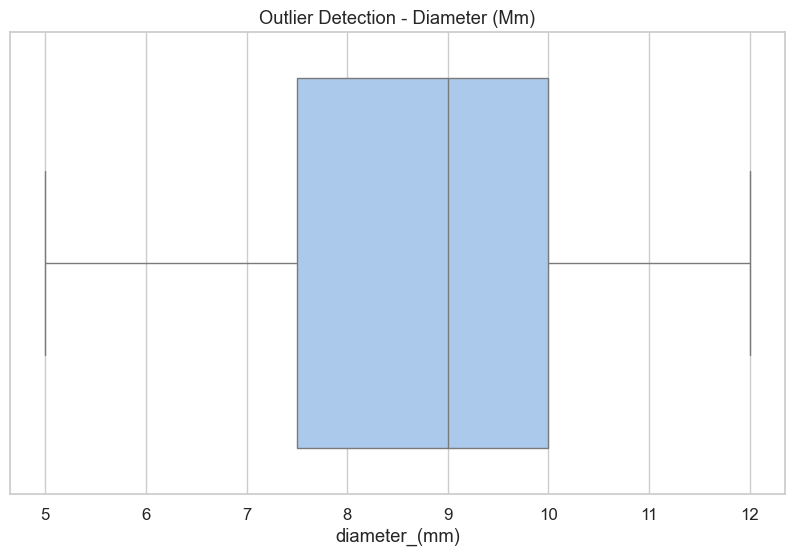

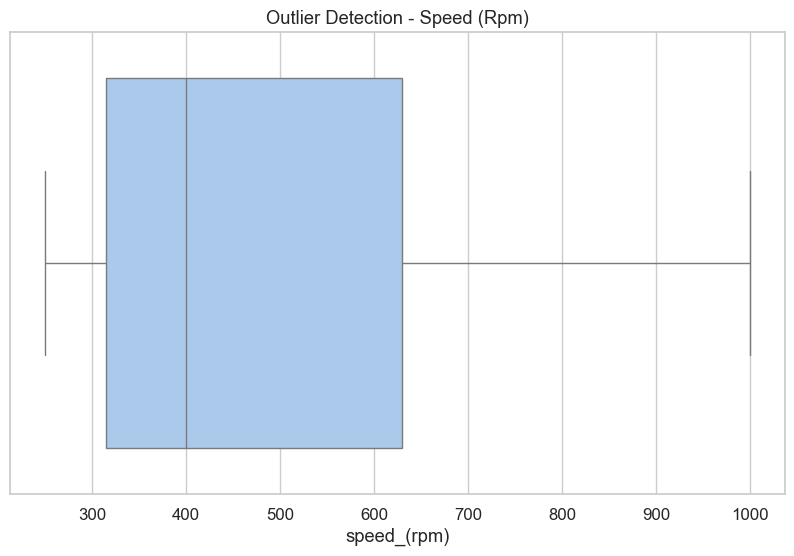

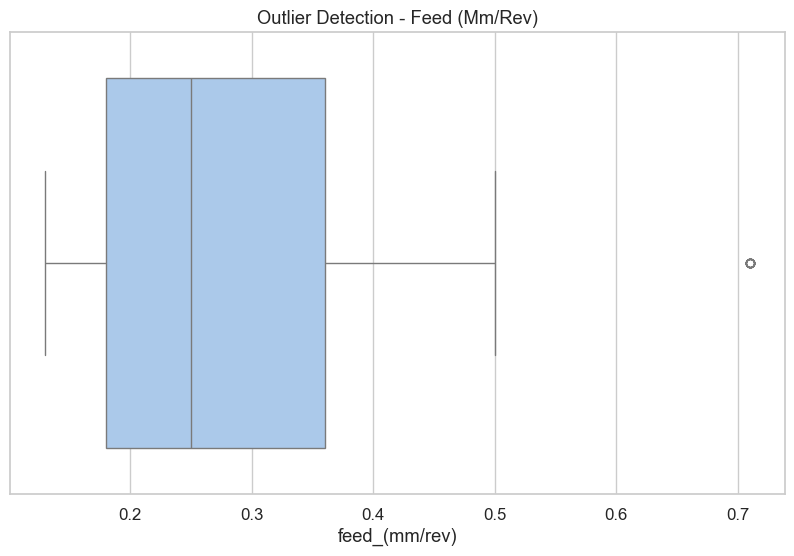

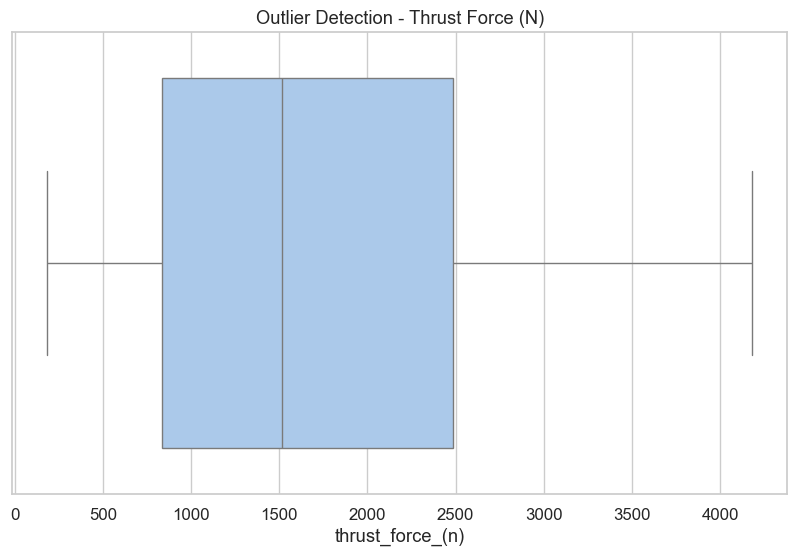

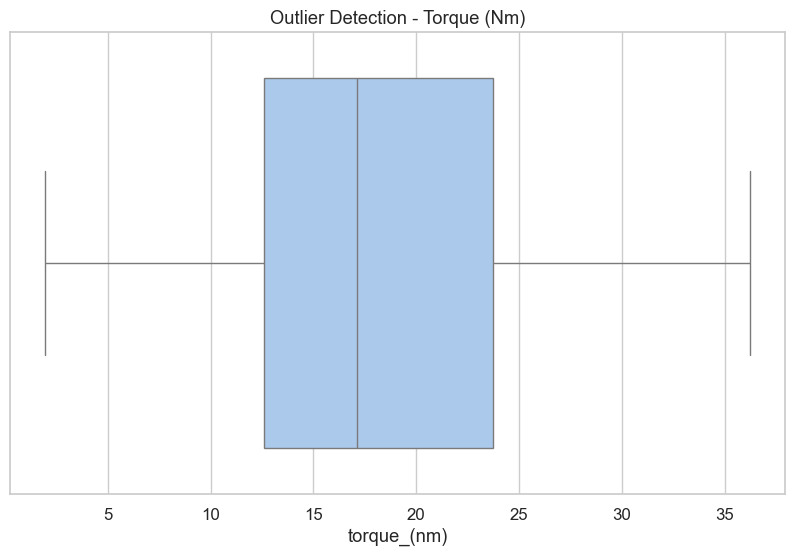

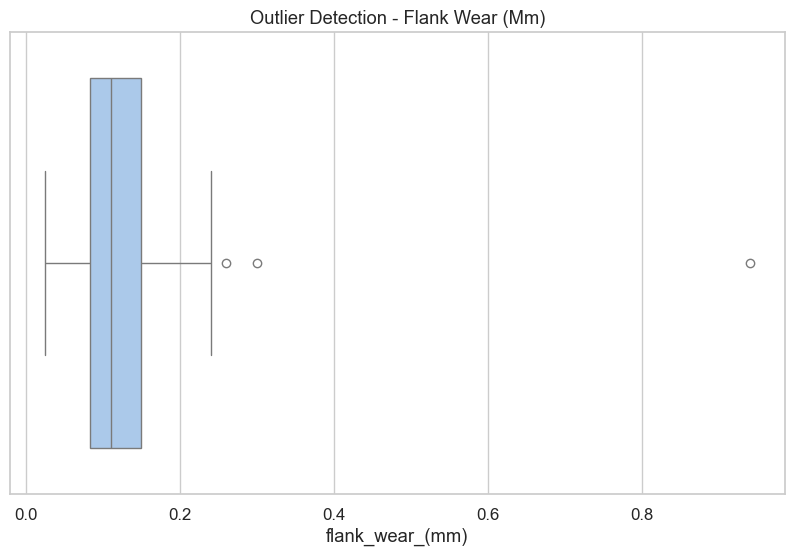

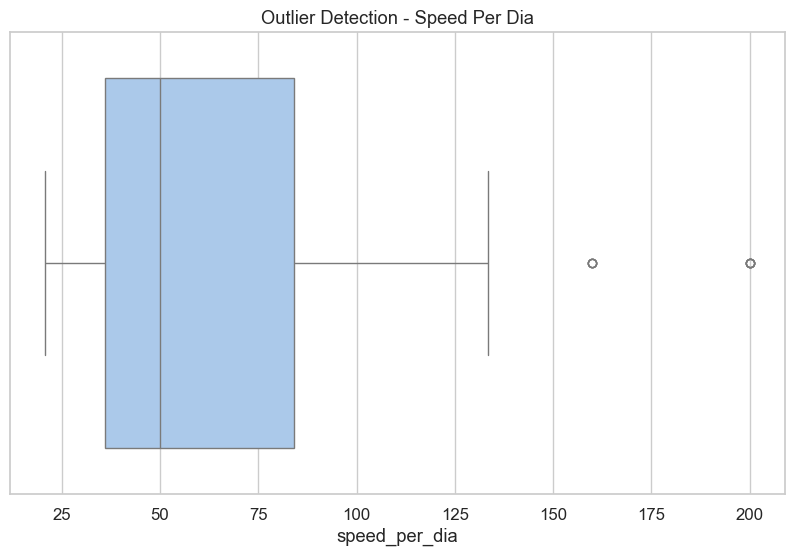

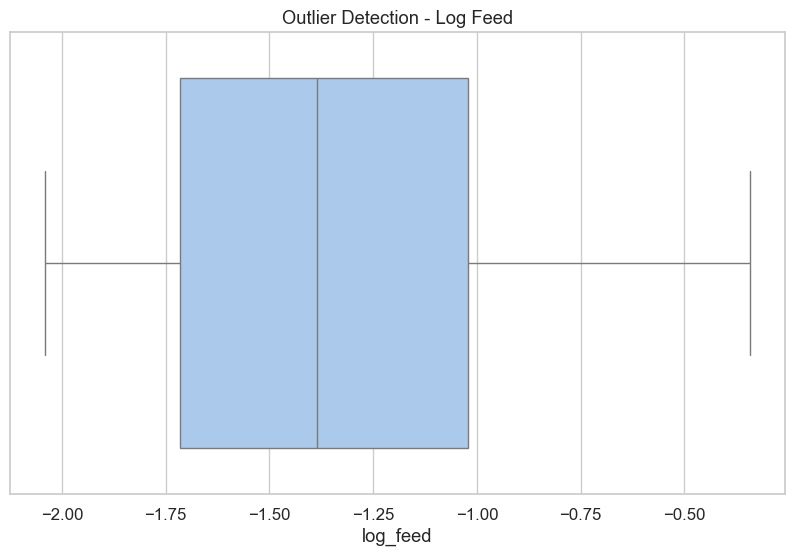

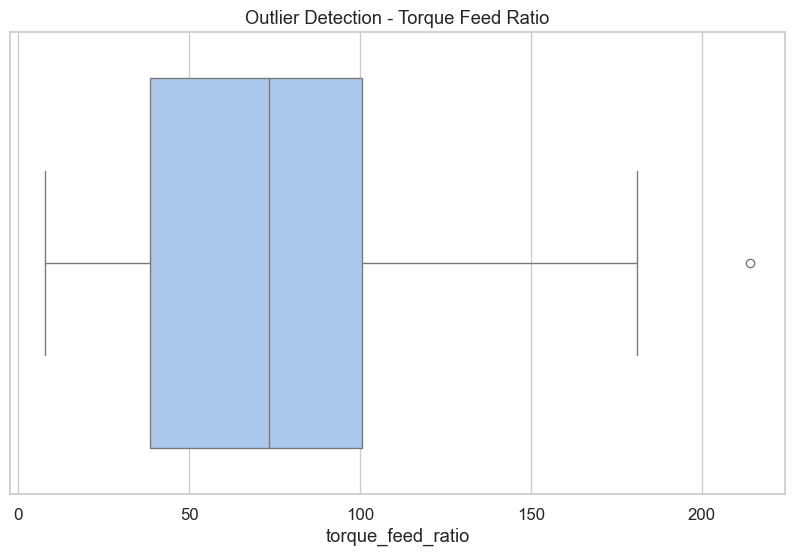

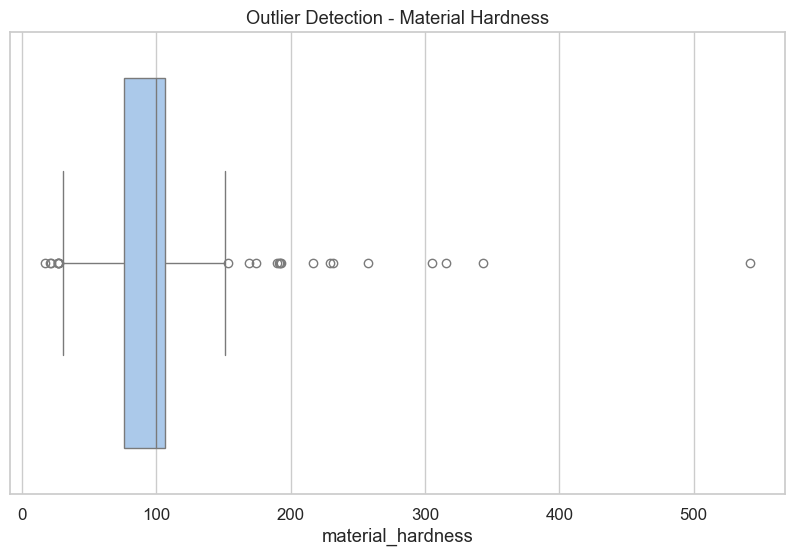

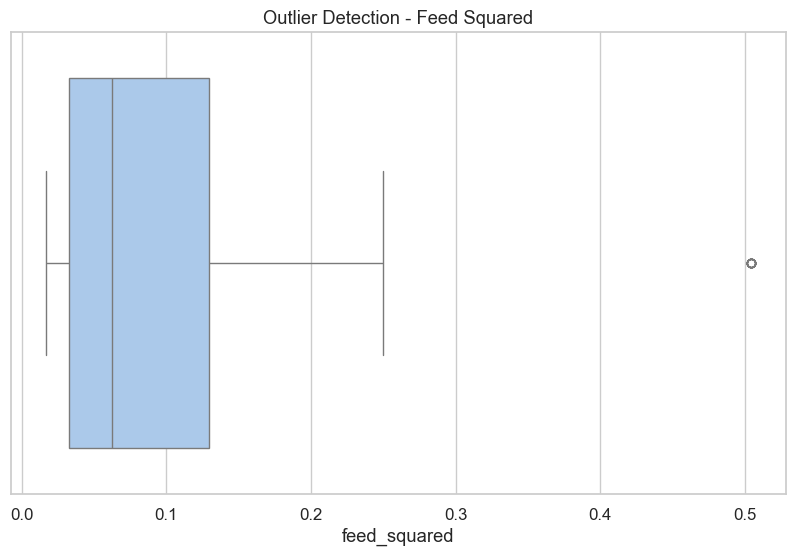

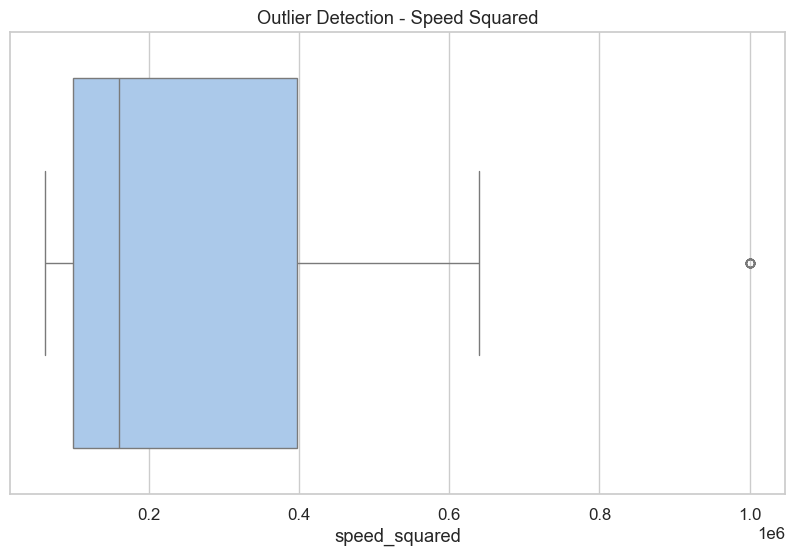

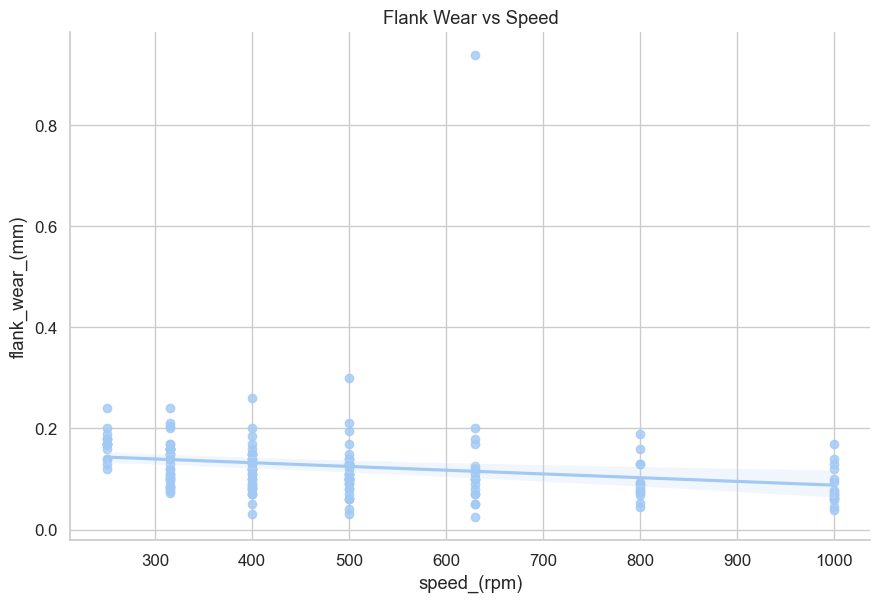

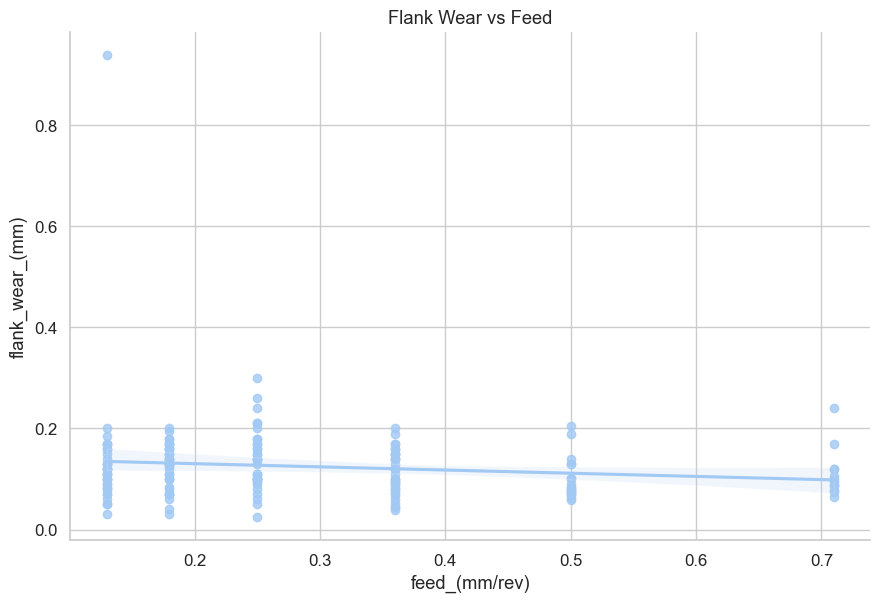

In [196]:
# General visualizations
from src.visualise_data import visualize
visualize(df_clean)

In [197]:
# Model tuning
from src.tune_models import tune_random_forest
best_rf, best_params, cv_results = tune_random_forest(X, y)
print("Best Params:", best_params)

import pandas as pd
cv_df = pd.DataFrame(cv_results)
cv_df = cv_df.sort_values(by='mean_test_score', ascending=False)
cv_df[['params', 'mean_test_score', 'rank_test_score']].head()

Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}


,params,mean_test_score,rank_test_score
2,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.098511,1
56,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",0.098511,1
38,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.098511,1
65,"{'max_depth': 30, 'max_features': 'log2', 'min...",0.098511,1
47,"{'max_depth': 20, 'max_features': 'log2', 'min...",0.098511,1


In [198]:
# Model training and evaluation
from src.model_train import train_models
results = train_models(X, y)

In [199]:
# Model training and evaluation
from src.model_train import train_models

results = train_models(X, y)

# Extract test set and predictions
X_test = results['X_test']
y_test = results['y_test']
models = results['models']
metrics = results['metrics']


🔍 Plotting for: RandomForest


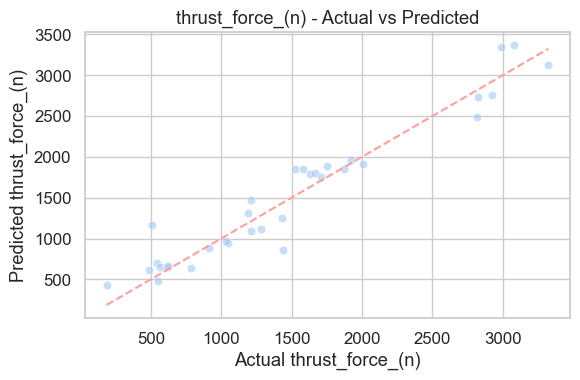

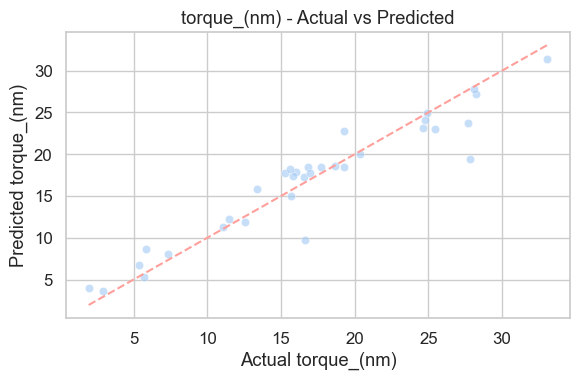

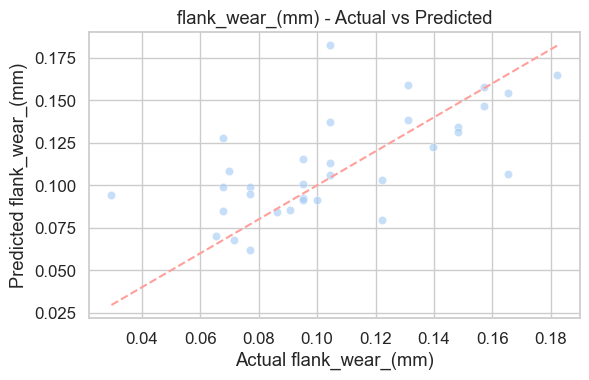

🔍 Plotting for: XGBoost


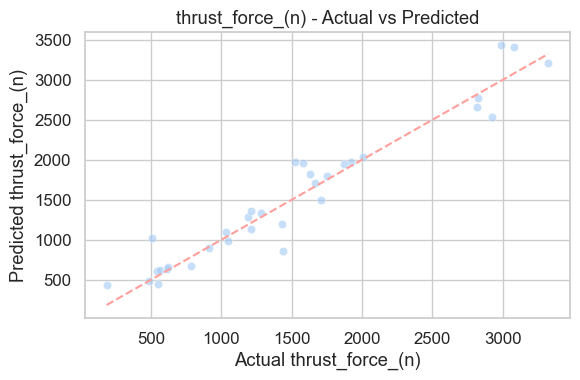

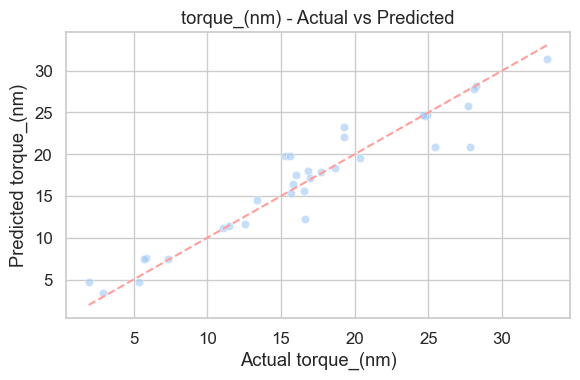

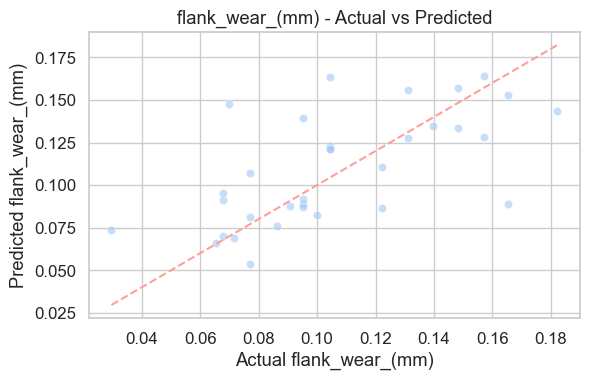

🔍 Plotting for: Ensemble


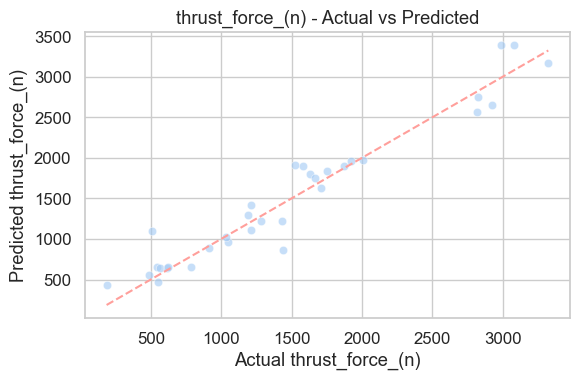

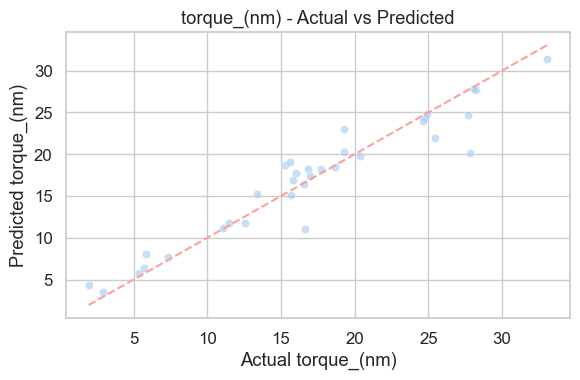

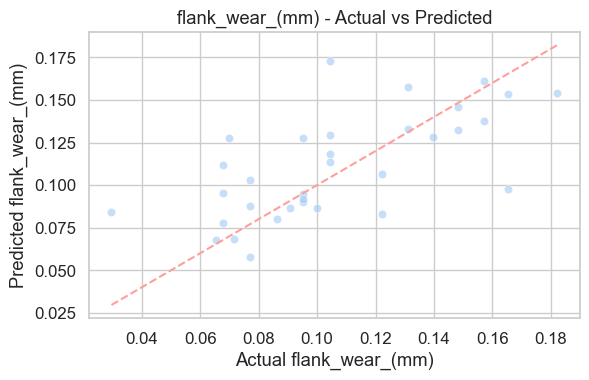

In [200]:
from src.evaluate_models import plot_predictions

for model_name in models:
    print(f"🔍 Plotting for: {model_name}")
    y_pred = models[model_name].predict(X_test)
    plot_predictions(y_test.values, y_pred, y.columns)


In [201]:
import numpy as np
for model_name, model_metrics in metrics.items():
    print(f"\n📌 {model_name} Metrics:")
    for metric_name, values in model_metrics.items():
        if isinstance(values, (list, tuple, np.ndarray)):  # Per-target metrics
            for i, target in enumerate(y.columns):
                print(f"  {metric_name} for {target}: {values[i]:.4f}")
        else:
            print(f"  {metric_name}: {values:.4f}")  # Scalar metric like MAPE
    print("-" * 40)



📌 RandomForest Metrics:
  R2 for thrust_force_(n): 0.9265
  R2 for torque_(nm): 0.8991
  R2 for flank_wear_(mm): 0.3582
  MAE for thrust_force_(n): 178.1715
  MAE for torque_(nm): 1.7170
  MAE for flank_wear_(mm): 0.0209
  MSE for thrust_force_(n): 53089.7956
  MSE for torque_(nm): 6.1994
  MSE for flank_wear_(mm): 0.0008
  RMSE for thrust_force_(n): 230.4122
  RMSE for torque_(nm): 2.4899
  RMSE for flank_wear_(mm): 0.0288
  MAPE: 19.7384
----------------------------------------

📌 XGBoost Metrics:
  R2 for thrust_force_(n): 0.9276
  R2 for torque_(nm): 0.9122
  R2 for flank_wear_(mm): 0.3340
  MAE for thrust_force_(n): 164.6754
  MAE for torque_(nm): 1.5542
  MAE for flank_wear_(mm): 0.0215
  MSE for thrust_force_(n): 52265.9922
  MSE for torque_(nm): 5.3981
  MSE for flank_wear_(mm): 0.0009
  RMSE for thrust_force_(n): 228.6176
  RMSE for torque_(nm): 2.3234
  RMSE for flank_wear_(mm): 0.0293
  MAPE: 18.1386
----------------------------------------

📌 Ensemble Metrics:
  R2 for thr

In [202]:
import pandas as pd

rows = []

for model_name, model_metrics in metrics.items():
    for i, target in enumerate(y.columns):
        row = {
            'Model': model_name,
            'Target': target,
            'R2': model_metrics['R2'][i],
            'MAE': model_metrics['MAE'][i],
            'MSE': model_metrics['MSE'][i],
            'RMSE': model_metrics['RMSE'][i], 
        }
        rows.append(row)

summary_df = pd.DataFrame(rows)
display(summary_df.sort_values(by='Target'))


,Model,Target,R2,MAE,MSE,RMSE
2,RandomForest,flank_wear_(mm),0.358239,0.020929,0.000830,0.028811
5,XGBoost,flank_wear_(mm),0.334027,0.021469,0.000861,0.029349
8,Ensemble,flank_wear_(mm),0.389990,0.020687,0.000789,0.028089
0,RandomForest,thrust_force_(n),0.926505,178.171534,53089.795617,230.412230
3,XGBoost,thrust_force_(n),0.927645,164.675354,52265.992188,228.617569
6,Ensemble,thrust_force_(n),0.930884,164.874644,49926.630493,223.442678
1,RandomForest,torque_(nm),0.899142,1.716952,6.199415,2.489863
4,XGBoost,torque_(nm),0.912177,1.554245,5.398145,2.323391
7,Ensemble,torque_(nm),0.912955,1.549936,5.350353,2.313083


In [203]:
from src.train_flankwear import train_flankwear_model

# Call custom function with engineered features and original wear target
fw_result = train_flankwear_model(X, df_clean['flank_wear_(mm)'])

print("📌 Best Parameters:", fw_result['params'])
print("📈 Metrics for Flank Wear (separate model):")
for k, v in fw_result['metrics'].items():
    print(f"{k}: {v:.4f}")


📌 Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
📈 Metrics for Flank Wear (separate model):
R2: 0.3801
MAE: 0.0243
MSE: 0.0010
RMSE: 0.0317
